In [1]:
import importlib
import state
import montecarlo as mc
import matplotlib.pyplot as plt
import cv2
import numpy as np
import vrobot
import math

importlib.reload(state)

<module 'state' from 'D:\\WorkSumo\\Courses\\333_robotics\\courseworks\\state.py'>

In [109]:
class Map:
    def __init__(self,starting_x=0, starting_y=0, enlargement_factor = 1, x_padding = 0, y_padding = 0, n_particles = 20):
        self.r = vrobot.Robot(starting_x = starting_x,
                             starting_y = starting_y,
                             n_particles = n_particles,
                             motion_sigma_distance=0.01, 
                             motion_sigma_angle=0.001, 
                             rotation_sigma_angle=0.001)
        
        self.walls = mc.walls
        self.enlargement_factor = enlargement_factor
        self.x_padding = x_padding
        self.y_padding = y_padding
        
        self.actual_x = starting_x
        self.actual_y = starting_y
        self.actual_t = 0
        
        self.print_weights = True
        self.sleep_time = 2
        
        #for debugging only, dont open it!
        #self.r.particle_cloud.randomize_particles(0,200,0,200, x_0=self.actual_x, y_0=self.actual_y, t_0=self.actual_t)
        
        self.measurement_var = 50
               
        self.draw_particles()
        self.pi = 3.14159
        
        self.display = np.zeros((250*self.enlargement_factor,250*self.enlargement_factor))
        
    def display_img(self):
        self.draw_map()
        self.draw_particles()
        plt.imshow(self.display)
        
    def report_robot(self):
        print(">>> robot at x="+str(self.r.particle_cloud.avg_x) +" y=" +str(self.r.particle_cloud.avg_y)+" theta="+str(self.r.particle_cloud.avg_theta * 180 / self.pi))
        
    def draw_map(self):
        for wall in self.walls:
            line = (self.enlargement_factor*wall[0]+self.x_padding, 
                    self.enlargement_factor*wall[1]+self.y_padding, 
                    self.enlargement_factor*wall[2]+self.x_padding, 
                    self.enlargement_factor*wall[3]+self.y_padding)
            cv2.line(self.display,(self.enlargement_factor*wall[0]+self.x_padding,self.enlargement_factor*wall[1]+self.y_padding),(self.enlargement_factor*wall[2]+self.x_padding,self.enlargement_factor*wall[3]+self.y_padding),255,2)
            
    def draw_particles(self):
        self.display = np.zeros((250*self.enlargement_factor,250*self.enlargement_factor))
        self.draw_map()
        if self.print_weights:
            max_w = np.max(self.r.particle_cloud.weights)
            for p,w in zip(self.r.particle_cloud.particles,self.r.particle_cloud.weights):
                #print("displaying at x=",int(self.enlargement_factor*p.x + self.x_padding),"y =",int(self.enlargement_factor*p.y + self.y_padding))
                cv2.circle(self.display,(int(self.enlargement_factor*p.x + self.x_padding),int(self.enlargement_factor*p.y + self.y_padding)), 3*self.enlargement_factor, int(w/max_w*255), -1)

        else:
            print_vector = [(p.x + self.x_padding, p.y + self.y_padding, p.theta) for p in self.r.particle_cloud.particles]
            cv2.circle(self.display,(self.enlargement_factor*p.x + self.x_padding,self.enlargement_factor*p.y + self.y_padding), 255, -1)
                
    def move_robot_forward(self,d,use_slam = False):
        self.r.travel_forwards(d)
        self.draw_particles()
        self.actual_x += d*math.cos(self.actual_t)
        self.actual_y += d*math.sin(self.actual_t)
        
    def rotate_robot(self,radian,direction = 'ccw',use_slam = False):
        if direction == 'ccw':
            self.r.rotate_on_spot(radian)
            self.draw_particles()
            self.actual_t += radian
        elif direction == 'cw':
            self.r.rotate_on_spot(-1*radian)
            self.draw_particles()
            self.actual_t -= radian
        else:
            print ("invalid direction command on Map.rotate_robot: please input ccw or cw")
        
    def move_robot_to(self,target_x,target_y):
        """
        Navigates to the given waypoint and stops.
        :param target_x: World frame x coordinate of target in cm
        :param target_y: World frame y coordinate of target in cm
        """
        # Convert coordinates into Robot frame
        x_diff = target_x - self.r.particle_cloud.avg_x
        y_diff = target_y - self.r.particle_cloud.avg_y
        tol = 10**-3
        
        # if the distance is not that great, forget it
        if abs(x_diff) < tol and abs(y_diff) < tol:
            return None

        world_frame_angle = math.atan2(y_diff,x_diff)
        robot_frame_angle = world_frame_angle - self.r.particle_cloud.avg_theta
        
        if robot_frame_angle < -self.pi:
            robot_frame_angle += 2*self.pi
            
        if robot_frame_angle > self.pi:
            robot_frame_angle -= 2*self.pi

        print("rotating " + str(robot_frame_angle * 180 / self.pi) + " degrees")
        self.rotate_robot(robot_frame_angle,direction='ccw',use_slam=True)
        print("rotated " + str(robot_frame_angle * 180 / self.pi) + " degrees")
        #self.report_robot()

        time.sleep(2)
        travel_distance = math.sqrt(x_diff**2 + y_diff**2)

        print("Moving forwards " + str(travel_distance) + " meters")
        self.move_robot_forward(travel_distance,use_slam=False)
        print("Moved forwards " + str(travel_distance) + " meters")
        #self.report_robot()

        time.sleep(2)
        
    def move_robot_to_slam(self,target_x,target_y):
        print("moving first half")
        x,y,theta = self.r.where_am_i()
        self.move_robot_to((target_x + x)/2.0,(target_y + y)/2.0)
        time.sleep(2)
        
        print("localizing robot")
        self.scan_sonar_and_update_batch()
        time.sleep(2)
        
        print("moving second half")
        self.move_robot_to(target_x,target_y)
        time.sleep(2)
        
        self.scan_sonar_and_update_batch()
                
    def move_robot_to2(self,target_x,target_y, use_slam = False):
        """
        Navigates to the given waypoint and stops.
        :param target_x: World frame x coordinate of target in cm
        :param target_y: World frame y coordinate of target in cm
        """
        # Convert coordinates into Robot frame
        x_diff = target_x - self.r.particle_cloud.avg_x
        y_diff = target_y - self.r.particle_cloud.avg_y
        tol = 10**-3
        
        # if the distance is not that great, forget it
        if abs(x_diff) < tol and abs(y_diff) < tol:
            return None

        world_frame_angle = math.atan2(y_diff,x_diff)
        robot_frame_angle = world_frame_angle - self.r.particle_cloud.avg_theta
        
        if robot_frame_angle < -self.pi:
            robot_frame_angle += 2*self.pi
            
        if robot_frame_angle > self.pi:
            robot_frame_angle -= 2*self.pi

        print("rotating " + str(robot_frame_angle * 180 / self.pi) + " degrees")
        self.rotate_robot(robot_frame_angle,direction='ccw',use_slam=True)
        print("rotated " + str(robot_frame_angle * 180 / self.pi) + " degrees")
        #self.report_robot()

        time.sleep(self.sleep_time)
        travel_distance = math.sqrt(x_diff**2 + y_diff**2)

        if use_slam:
            print("Moving forwards " + str(travel_distance) + " meters")
            n_steps = 5.0
            for i in range(int(n_steps)):
                self.move_robot_forward(travel_distance/n_steps,use_slam = False)
                self.update_particle_all() 
                self.draw_particles()
                time.sleep(1)
                
                current_x = self.r.particle_cloud.avg_x
                current_y = self.r.particle_cloud.avg_y
                current_theta = self.r.particle_cloud.avg_theta
                print(">>> World_frame_angle = "+str(world_frame_angle)+" current_angle = "+str(current_theta) + " error = " + str(world_frame_angle - current_theta))
                
                if abs(world_frame_angle - current_theta) > 0.016:
                    print(">>> Robot out of course, world_frame_angle = "+str(world_frame_angle)+" current_angle = "+str(current_theta))
                    #self.move_robot_to(target_x,target_y, use_slam = False)
                    self.rotate_robot(world_frame_angle - current_theta,direction='ccw',use_slam=False)
                    time.sleep(1)
                                        
            print("Moved forwards " + str(travel_distance) + " meters")
            
            self.update_particle_all() 
            self.draw_particles()
            time.sleep(1)
                
            current_x = self.r.particle_cloud.avg_x
            current_y = self.r.particle_cloud.avg_y
            current_theta = self.r.particle_cloud.avg_theta
            
            distance_error = math.sqrt((target_x-current_x)**2 + (target_y - current_y)**2)
            print("Performing final correction of " + str(distance_error) + " meters")
            self.move_robot_forward(distance_error,use_slam=False)
            print("Destination reached")
            
        else:
            print("Moving forwards " + str(travel_distance) + " meters")
            self.move_robot_forward(travel_distance,use_slam=False)
            print("Moved forwards " + str(travel_distance) + " meters")
            #self.report_robot()

        time.sleep(self.sleep_time)
        
    def get_robot_measurement(self):
        wall,dist = mc.find_relevant_wall((self.actual_x,self.actual_y,self.actual_t+self.r.particle_cloud.sonar_angle),mc.walls)
        return dist + np.random.normal(loc = 0, scale = 9)
    
    def update_particle_weights(self):
        measurement_distance = self.get_robot_measurement()
        self.r.particle_cloud.update_weights(measurement_distance, self.measurement_var)
        self.draw_particles()
    
    def update_particle_all(self):
        measurement_distance = self.get_robot_measurement()
        self.r.particle_cloud.update_cloud_from_measurement(measurement_distance,self.measurement_var)        
        self.draw_particles()
        
    def update_particles_at_angle(self,theta):
        self.r.rotate_sonar_to(theta)
        time.sleep(1)
        self.update_particle_all()
    
    def scan_sonar_and_update(self):
        for theta in np.linspace(-1*math.pi,math.pi,7):
            # rotate the sonar by 30 degree from -180 to 180 (7 steps)
            self.update_particles_at_angle(theta)
            
        self.r.rotate_sonar_to(0.0)
        
    def scan_sonar_and_update_batch(self, weights_only = False):
        print("actual robot at x=",self.actual_x,"y=",self.actual_y,"t=",self.actual_t)
        thetas = []
        measurements = []
        
        print(">>> taking measurements")
        
        self.r.rotate_sonar_to(-1*math.pi)
        
        for theta in np.linspace(-1*math.pi,5.0/6.0*math.pi,4):
            # rotate the sonar by 30 degree from -180 to 120 (6 steps)
            thetas.append(theta)
            
            self.r.rotate_sonar_to(theta)
            measurements.append(self.get_robot_measurement())
                     
        print("===== measurement summary =====")
        print(np.array(thetas)*180/math.pi)
        print(measurements)
        print("===============================")
        
        self.r.rotate_sonar_to(0.0)
        print(">>> updating particles")
        #the first measurement is often errorneous
        self.r.particle_cloud.update_cloud_from_measurement_batch(thetas,measurements,self.measurement_var, weights_only)
        print(">>> drawing particles")
        self.draw_particles()
        print(">>> done localizing")


In [110]:
m = Map(starting_x=10,starting_y=10,enlargement_factor=3, n_particles=100)

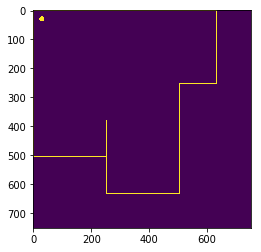

In [111]:
m.rotate_robot(math.pi/6)
m.display_img()

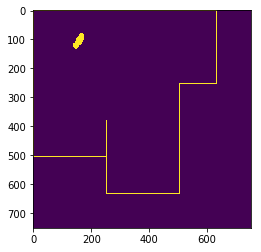

In [112]:
m.move_robot_forward(50)
m.display_img()

In [113]:
m.scan_sonar_and_update_batch(weights_only=True)

actual robot at x= 53.30127018922194 y= 35.0 t= 0.5235987755982988
>>> taking measurements
===== measurement summary =====
[-180.  -70.   40.  150.]
[65.21677782672494, 56.588045299627126, 185.11455890416093, 54.42634580406534]
>>> updating particles
index = 0x = 54.87403052351089y = 31.700875264133778 z = 0.4504380225417043
[65.21677782672494, 45.477807516470484, 195.4651140564035, 55.021215266939045]
[65.21677782672494, 56.588045299627126, 185.11455890416093, 54.42634580406534]
index = 1x = 51.95538439674959y = 35.822532917337455 z = 0.5517212760578659
[65.21677782672494, 57.68587000249794, 101.57999258620114, 51.97593627733443]
[65.21677782672494, 56.588045299627126, 185.11455890416093, 54.42634580406534]
index = 2x = 50.94892761311726y = 38.29026636896907 z = 0.6045701582576806
[65.21677782672494, 66.1635267510707, 124.77072098921143, 51.11640497895698]
[65.21677782672494, 56.588045299627126, 185.11455890416093, 54.42634580406534]
index = 3x = 52.94320785028352y = 37.22984323425363

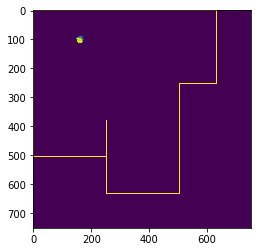

In [114]:
m.display_img()

In [115]:
m.scan_sonar_and_update_batch(weights_only=False)

actual robot at x= 53.30127018922194 y= 35.0 t= 0.5235987755982988
>>> taking measurements
===== measurement summary =====
[-180.  -70.   40.  150.]
[63.771227474353104, 58.675632932129, 195.13255082540854, 43.950148337508224]
>>> updating particles
index = 0x = 54.87403052351089y = 31.700875264133778 z = 0.4504380225417043
[63.771227474353104, 45.477807516470484, 195.4651140564035, 55.021215266939045]
[63.771227474353104, 58.675632932129, 195.13255082540854, 43.950148337508224]
index = 1x = 51.95538439674959y = 35.822532917337455 z = 0.5517212760578659
[63.771227474353104, 57.68587000249794, 101.57999258620114, 51.97593627733443]
[63.771227474353104, 58.675632932129, 195.13255082540854, 43.950148337508224]
index = 2x = 50.94892761311726y = 38.29026636896907 z = 0.6045701582576806
[63.771227474353104, 66.1635267510707, 124.77072098921143, 51.11640497895698]
[63.771227474353104, 58.675632932129, 195.13255082540854, 43.950148337508224]
index = 3x = 52.94320785028352y = 37.22984323425363 

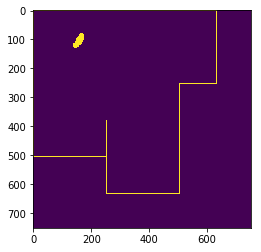

In [116]:
m.display_img()

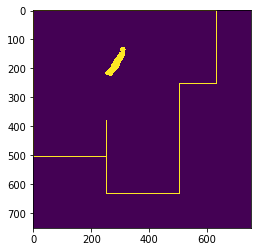

In [117]:
m.move_robot_forward(50)
m.display_img()

In [118]:
m.scan_sonar_and_update_batch(weights_only=False)

actual robot at x= 96.60254037844388 y= 60.0 t= 0.5235987755982988
>>> taking measurements
===== measurement summary =====
[-180.  -70.   40.  150.]
[132.89460569260277, 103.5062285055014, 163.996213177151, 102.12917183371226]
>>> updating particles
index = 0x = 97.48276713992763y = 57.47356454119401 z = 0.4815162305368641
[132.89460569260277, 85.21594785785281, 164.9876484023029, 97.56914897426408]
[132.89460569260277, 103.5062285055014, 163.996213177151, 102.12917183371226]
index = 1x = 95.28390680516969y = 64.93056182048934 z = 0.6016327780962825
[132.89460569260277, 111.73450768825413, 150.565819780716, 95.57475110454573]
[132.89460569260277, 103.5062285055014, 163.996213177151, 102.12917183371226]
index = 2x = 94.50543652233159y = 62.32081782650352 z = 0.5651233896098493
[132.89460569260277, 102.09281383351289, 154.94928525890785, 94.5869726596267]
[132.89460569260277, 103.5062285055014, 163.996213177151, 102.12917183371226]
index = 3x = 98.41503440370481y = 57.40035670560964 z = 

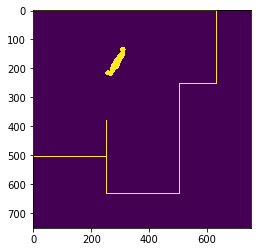

In [119]:
m.display_img()